In [3]:
import numpy as np
import matplotlib.pyplot as plt

days = 20  
obs_per_day = 12
nobs = 240
X = np.arange(0, days, 1./(obs_per_day * 1000))
alpha = 0.6
beta = 0.75 
delta = 1. 
gamma = np.concatenate((0.8 * np.ones(60000), 1.2 * np.ones(60000), 0.8 * np.ones(60000), 1.2 * np.ones(60000)))

# data generation for 20 years with monthly observations
def recover_data(alpha, beta, delta, gamma, days, obs_per_day, state0=[3., 1.], linspace=1000, noise=True):
    nobs = days
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((days * linspace * obs_per_day, 2))
    state_ls[0] = state0.copy()
    for i in range(1, linspace * days * obs_per_day):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (
                    alpha * state_ls[i - 1][0] - beta * state_ls[i - 1][0] * state_ls[i - 1][1])
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (
                    delta * state_ls[i - 1][0] * state_ls[i - 1][1] - gamma[index]  * state_ls[i - 1][1])
    states = state_ls[::linspace]

    return states

true_x = recover_data(alpha, beta, delta, gamma, days, obs_per_day)

def gen_data(alpha, beta, delta, gamma, days, obs_per_day, state0=[3., 1.], linspace=1000, noise=True):
    nobs = days
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((days * linspace * obs_per_day, 2))
    state_ls[0] = state0.copy()
    for i in range(1, linspace * days * obs_per_day):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (
                    alpha * state_ls[i - 1][0] - beta * state_ls[i - 1][0] * state_ls[i - 1][1])
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (
                    delta * state_ls[i - 1][0] * state_ls[i - 1][1] - gamma[index]  * state_ls[i - 1][1])
    states = state_ls[::linspace]
    states *= np.random.normal(1, 0.03, states.shape)
    return states


observations = gen_data(alpha, beta, delta, gamma, days, obs_per_day)
observations

array([[3.15684194e+00, 9.77826515e-01],
       [2.90976245e+00, 1.21070352e+00],
       [2.90694676e+00, 1.44551887e+00],
       [2.72658843e+00, 1.75175168e+00],
       [2.63334203e+00, 2.04804600e+00],
       [2.21001568e+00, 2.23172393e+00],
       [2.03216779e+00, 2.56621831e+00],
       [1.87764178e+00, 2.78688581e+00],
       [1.63483206e+00, 2.92591143e+00],
       [1.47584961e+00, 3.14868392e+00],
       [1.20239686e+00, 3.27603814e+00],
       [1.02202428e+00, 3.36778666e+00],
       [8.82127957e-01, 3.40179048e+00],
       [7.68371420e-01, 3.61494198e+00],
       [6.13437635e-01, 3.47335478e+00],
       [5.07359935e-01, 3.39471534e+00],
       [4.58120948e-01, 3.26527122e+00],
       [3.81713633e-01, 3.22622933e+00],
       [3.39875335e-01, 3.18824143e+00],
       [2.78710416e-01, 3.11347431e+00],
       [2.43924721e-01, 2.92898007e+00],
       [2.18815792e-01, 2.72136142e+00],
       [2.00347418e-01, 2.62629354e+00],
       [1.77081512e-01, 2.45611845e+00],
       [1.626905

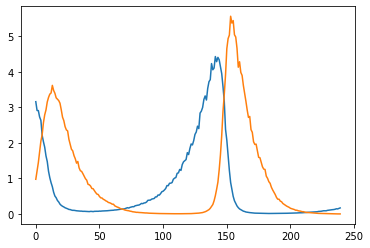

In [4]:
plt.plot(observations[:, 0])
plt.plot(observations[:, 1])

In [6]:
import numpy as np
import torch
import scipy
import argparse
import sys
import matplotlib.pyplot as plt
import matplotlib
from arma import ode_system, solve_magi
from arma import matrix
import time
import pickle
from multiprocessing import Pool

%matplotlib inline
from IPython.core.pylabtools import figsize # import figsize
#figsize(12.5, 4) # 设置 figsize
plt.rcParams['savefig.dpi'] = 200 #图片像素
plt.rcParams['figure.dpi'] = 200 #分辨率
torch.set_num_threads(1)


def fOde(theta, x):
    """
    description of ODE
    theta: list[4]
    return: array(n, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    Rdt = theta[0] * rabbit - theta[1] * rabbit * fox
    Fdt = theta[2] * rabbit * fox - theta[3] * fox
    return np.stack([Rdt, Fdt], axis=1)

def fOdeDx(theta, x):
    """
    returns ODE derivation of x given theta
    theta: list[4]
    x: array(n, 2)
    return: array(n, 2, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    resultDx = np.zeros(shape=[np.shape(x)[0], 2, 2])
    # [:, i, j]: jth equation derivative of the ith state
    # (0) / dR
    resultDx[:, 0, 0] = theta[0] - theta[0] * fox
    # (0) / dF
    resultDx[:, 1, 0] =  -theta[0] * rabbit
    # (1) / dR
    resultDx[:, 0, 1] = theta[2] * fox
    # (1) / dF
    resultDx[:, 0, 1] = theta[2] * rabbit - theta[3]
    return resultDx

def fOdeDtheta(theta, x):
    """
    returns ODE derivation of theta given x
    theta: list[4]
    x: array(n, 2)
    return: array(n, 4, 2)
    """
    resultDtheta = np.zeros(shape=[np.shape(x)[0], 4, 2])
    # [:, i, j]: jth equation derivative of the ith theta
    rabbit = x[:, 0]
    fox = x[:, 1]
    # (0) / 0
    resultDtheta[:, 0, 0] = rabbit
    # (0) / 1
    resultDtheta[:, 1, 0] = -rabbit * fox
    # (1) / 2
    resultDtheta[:, 2, 1] = rabbit * fox
    # (1) / 3
    resultDtheta[:, 3, 1] = -fox
    return resultDtheta

def copy_mat(arma_mat):
    return np.copy(matrix(arma_mat).reshape([-1])).reshape([arma_mat.n_rows, arma_mat.n_cols])

  



In [7]:
# def TVMAGI_solver(use_data_idx, fOde=fOde, fOdeDx=fOdeDx, fOdeDtheta=fOdeDtheta,
days = 20
discretization = 1
obs_per_day = 12 
theta_lowerbound=np.array([0., 0., 0., 0.])
theta_upperbound=np.array([np.inf, np.inf, np.inf, np.inf])
param_names = ['alpha', 'beta', 'delta', 'gamma']
is_time_varying=[False, False, False, True] 
use_trajectory='inferred'
learning_rate=np.array([1e-4, 1e-3, 1e-5])
n_iter = [15001, 200000, 15000, 200000]
    
yobs = observations
start_time = time.time()
nobs, p_dim = yobs.shape[0], yobs.shape[1]
n_points = nobs * discretization
theta_dim = theta_lowerbound.shape[0]
d_matrix = torch.zeros((n_points, n_points), dtype=torch.double)
for i in range(n_points):
    for j in range(n_points):
        if i > j:
            d_matrix[i][j] = (i - j) / (obs_per_day * discretization)
        else:
            d_matrix[i][j] = (j - i) / (obs_per_day * discretization)
Ode_system = ode_system("ODE-python", fOde, fOdeDx, fOdeDtheta,
                         thetaLowerBound=theta_lowerbound,
                         thetaUpperBound=theta_upperbound)
tvecObs = np.arange(0, days, 1. / obs_per_day)
tvecFull = np.arange(0, days, 1. / (obs_per_day * discretization))
yFull = np.ndarray([n_points, p_dim])
yFull.fill(np.nan)
yFull[np.arange(0, discretization * nobs, discretization).astype(int), :] = yobs
xInitExogenous = np.zeros_like(yFull)
# interpolate: find the ydata of tvecFull given observations
for i in range(p_dim):
    xInitExogenous[:, i] = np.interp(tvecFull, tvecObs, yobs[:, i])
# First stage: use MAGI package to optimize theta as constant
result = solve_magi(
    yFull,
    Ode_system,
    tvecFull,
    sigmaExogenous=np.array([]),
    phiExogenous=np.array([[]]),
    xInitExogenous=xInitExogenous,
    thetaInitExogenous=np.array([]),
    muExogenous=np.array([[]]),
    dotmuExogenous=np.array([[]]),
    priorTemperatureLevel=yFull.shape[0] / yobs.shape[0],
    priorTemperatureDeriv=yFull.shape[0] / yobs.shape[0],
    priorTemperatureObs=1.0,
    kernel="generalMatern",
    nstepsHmc=100,
    burninRatioHmc=0.5,
    niterHmc=n_iter[0],
    stepSizeFactorHmc=0.01,
    nEpoch=1,
    bandSize=40,
    useFrequencyBasedPrior=True,
    useBand=False,
    useMean=False,
    useScalerSigma=False,
    useFixedSigma=False,
    verbose=True)
samplesCpp = result['samplesCpp']
llikId = 0
xId = range(np.max(llikId) + 1, np.max(llikId) + yFull.size + 1)
# dimension of theta
thetaId = range(np.max(xId) + 1, np.max(xId) + theta_dim + 1)
sigmaId = range(np.max(thetaId) + 1, np.max(thetaId) + yFull.shape[1] + 1)
burnin = int(n_iter[0] * 0.5)
xsampled = samplesCpp[xId, (burnin + 1):]
xsampled = xsampled.reshape([yFull.shape[1], yFull.shape[0], -1])
CovAllDimensionsPyList = []
thetaSampled = samplesCpp[thetaId, (burnin + 1):]
inferred_theta = np.mean(thetaSampled, axis=-1)
sigmaSampled = samplesCpp[sigmaId, (burnin + 1):]
inferred_sigma = np.mean(sigmaSampled, axis=-1)
inferred_trajectory = np.mean(xsampled, axis=-1)
for each_gpcov in result['result_solved'].covAllDimensions:
    each_pycov = dict(
        Cinv=torch.from_numpy(matrix(each_gpcov.Cinv)).double(),
        Kinv=torch.from_numpy(matrix(each_gpcov.Kinv)).double(),
        mphi=torch.from_numpy(matrix(each_gpcov.mphi)).double(),
    )
    CovAllDimensionsPyList.append(each_pycov)

In [10]:
ydata.shape

torch.Size([240, 2])

In [13]:
def fOdeTorch(theta, x, constant_param_ls):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    Rdt = constant_param_ls[0] * rabbit - constant_param_ls[1] * rabbit * fox
    Fdt = constant_param_ls[2] * rabbit * fox - theta[:, 0] * fox
    return torch.stack([Rdt, Fdt], axis=1)


def pointwisethetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    #  prior distriobution of X
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]
    return torch.sum(res)


TV_theta_mean = np.zeros(int(sum(is_time_varying)))
tv_index = 0
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == True:
        TV_theta_mean[tv_index] = inferred_theta[thetaEachDim]
        tv_index += 1

if use_trajectory == 'observation':
    pointwise_xlatent_torch = torch.tensor(xInitExogenous, requires_grad=True, dtype=torch.double)
elif use_trajectory == 'inferred':
    pointwise_xlatent_torch = torch.tensor(inferred_trajectory.transpose(), requires_grad=True, dtype=torch.double)
else:
    raise ValueError
tmp1 = np.array([TV_theta_mean])
initial_tvtheta = np.repeat(tmp1, pointwise_xlatent_torch.shape[0], axis=0)
pointwise_theta_torch = torch.tensor(initial_tvtheta, requires_grad=True, dtype=torch.double)
sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
time_constant_param_ls = []
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == False:
        param_name = param_names[thetaEachDim]
        print(param_name)
        globals()[param_name] = torch.tensor([inferred_theta[thetaEachDim]], requires_grad=True, dtype=torch.double)
        print(eval(param_name))
        time_constant_param_ls.append(eval(param_name))

ydata = torch.from_numpy(yFull).double()
priorTemperature = torch.tensor([discretization, discretization, 1.0])  # ?
pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch, pointwise_theta_torch, sigma_torch] + time_constant_param_ls, lr=1e-4)  # , weight_decay = 1.0
pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=10000, gamma=0.5)
cur_loss = 1e20
for epoch in range(n_iter[1]):
    pointwise_optimizer.zero_grad()
    # compute loss function
    llik = pointwisethetasigmallikTorch(pointwise_xlatent_torch, pointwise_theta_torch, time_constant_param_ls, sigma_torch,
                                        ydata, CovAllDimensionsPyList, fOdeTorch,
                                        priorTemperature)
    new_loss = -llik
    if epoch % 200 == 0:
        print(epoch, new_loss.item())
        diff = new_loss.item() - cur_loss
        if torch.isnan(new_loss) == False and diff > -0.01 and diff < 0.01:
            break
        cur_loss = new_loss.item()
    new_loss.backward()
    pointwise_optimizer.step()
    pointwise_lr_scheduler.step()

alpha
tensor([0.5963], dtype=torch.float64, requires_grad=True)
beta
tensor([0.7361], dtype=torch.float64, requires_grad=True)
delta
tensor([1.0085], dtype=torch.float64, requires_grad=True)
0 -1100.8118001400826


/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


200 -1136.1610848489447
400 -1156.776278465853
600 -1172.4864677956234
800 -1185.0233407636388
1000 -1195.1958756296451
1200 -1203.5061501601333
1400 -1210.307860992369
1600 -1215.8781514323377
1800 -1220.452075501747
2000 -1224.2310912775984
2200 -1227.381920834861
2400 -1230.03830301409
2600 -1232.3001064205662
2800 -1234.241309446216
3000 -1235.9139672220574
3200 -1237.3561952196683
3400 -1238.5964952122501
3600 -1239.6583061151393
3800 -1240.561249695479
4000 -1241.3239072376646
4200 -1241.9624487519477
4400 -1242.4921532193907
4600 -1242.9278916710937
4800 -1243.282632434879
5000 -1243.5695194597088
5200 -1243.7990597540447
5400 -1243.98260764645
5600 -1244.1283801253708
5800 -1244.2444295460166
6000 -1244.3380919657202
6200 -1244.4145475184844
6400 -1244.4779593068379
6600 -1244.5320331115527
6800 -1244.5790659100735
7000 -1244.6210658381947
7200 -1244.659596501885
7400 -1244.694677860689
7600 -1244.7274232656014
7800 -1244.7578738113998
8000 -1244.786124369159
8200 -1244.8126043

In [27]:
pointwise_theta_torch.detach().numpy()[:, 0]

array([ 0.32546781,  0.59237742,  0.74942989,  0.87655726,  0.98674058,
        1.02641299,  1.02325105,  1.00268605,  0.9380653 ,  0.85775958,
        0.78721417,  0.72276915,  0.69044708,  0.74617011,  0.83234452,
        0.83895353,  0.76006448,  0.6749147 ,  0.67975409,  0.77948892,
        0.88299113,  0.89804787,  0.83663446,  0.75897912,  0.73547071,
        0.82592499,  0.93613109,  0.94885986,  0.8820203 ,  0.82076872,
        0.79031488,  0.7492696 ,  0.70760946,  0.7441969 ,  0.79528154,
        0.74483868,  0.69838944,  0.73186647,  0.8055121 ,  0.8743546 ,
        0.91402908,  0.86127658,  0.75435809,  0.71006102,  0.71086589,
        0.7666636 ,  0.86375099,  0.90898927,  0.89661894,  0.8967609 ,
        0.88690593,  0.80851572,  0.7486571 ,  0.75009439,  0.77610546,
        0.7988781 ,  0.79223352,  0.7470427 ,  0.71194916,  0.75875226,
        0.8901038 ,  1.11204019,  1.29195573,  1.30466936,  1.25666288,
        1.24907361,  1.24813601,  1.18220617,  1.15159302,  1.19

In [19]:
def construct(vals, occurence_times):
    ls = []
    for idx in range(len(vals)):
        if occurence_times[idx] != 0:
            for i in range(occurence_times[idx]):
                ls.append(vals[idx])
    return torch.cat(ls, axis=0).reshape(-1, vals.shape[1])
    
def new_likelihood(xlatent, vals, occurence_times, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature):
    new_theta = construct(vals, occurence_times)
    return pointwisethetasigmallikTorch(xlatent, new_theta, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature)



vals = pointwise_theta_torch.detach().clone()
# Initialize occurence times, sum(cur_occurence_times) = len(theta)
occurence_times = np.ones(len(vals)).astype(int)
pointwise_xlatent_torch.requires_grad = False
sigma_torch.requires_grad = False
total_iter = 238
vals_ls = np.zeros((total_iter, len(vals)))
occurence_times_ls = np.zeros((total_iter, len(vals)))
lik_ls = np.zeros(len(vals))
for EachIter in range(total_iter):
    print('Iteration: ', EachIter, '\n')
    n_clusters = np.count_nonzero(occurence_times)
    cur_loss = np.inf
    cur_best_idx = -1
    cur_occurence_times = occurence_times.copy()
    for idx in range(len(vals)-1):
        if occurence_times[idx] == 0:
            continue
        else:
            print('Current index: ', idx)
            # find the next index of theta value
            next_idx = idx + 1
            while next_idx <= len(vals)-1:
                if occurence_times[next_idx]:
                    break
                next_idx += 1
            # if there is no such next index, continue to the next iteration  
            if next_idx >= len(vals):
                continue      
            cur_vals = vals.detach().clone()
            new_val = (cur_vals[idx] + cur_vals[next_idx]) / 2
            new_vals = cur_vals.detach().clone()
            new_vals[idx], new_vals[next_idx] = new_val, new_val
            new_occurence_times = cur_occurence_times.copy()
            new_occurence_times[idx] = cur_occurence_times[idx] + cur_occurence_times[next_idx]
            new_occurence_times[next_idx] = 0
            pointwise_xlatent_torch_tmp = pointwise_xlatent_torch.detach().clone()
            pointwise_xlatent_torch_tmp.requires_grad = True
            time_constant_param_ls_tmp = time_constant_param_ls.copy()
            sigma_torch_tmp = sigma_torch.detach().clone()
            # Define new initial theta
            print(new_likelihood(pointwise_xlatent_torch_tmp, new_vals_tmp, new_occurence_times, time_constant_param_ls_tmp, sigma_torch_tmp,
                                            ydata, CovAllDimensionsPyList, fOdeTorch,
                                            priorTemperature))
            pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch_tmp, new_vals_tmp, sigma_torch_tmp] + time_constant_param_ls_tmp, lr=1e-4)  # , weight_decay = 1.0
            pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=5000, gamma=0.5)
            cur_loss_tmp = np.inf
            for epoch in range(100000):
                pointwise_optimizer.zero_grad()
                # compute loss function
                llik = new_likelihood(pointwise_xlatent_torch_tmp, new_vals_tmp, new_occurence_times, time_constant_param_ls, sigma_torch,
                                            ydata, CovAllDimensionsPyList, fOdeTorch,
                                            priorTemperature)
                new_loss = -llik
                if epoch % 200 == 0:
                    print(epoch, new_loss.item())
                    diff = new_loss.item() - cur_loss_tmp
                    if torch.isnan(new_loss) == False and diff > -1. and diff < 1.:
                        break
                    cur_loss_tmp = new_loss.item()
                new_loss.backward()
                pointwise_optimizer.step()
                pointwise_lr_scheduler.step()
            if cur_loss > new_loss.item():
                cur_loss = new_loss.item()
                cur_best_idx = idx
                cur_best_occurence_times = new_occurence_times.copy()
                print('Update change point!')
                cur_best_vals = new_vals_tmp.detach().clone()
                print('Updated change point list: ', cur_best_occurence_times)
    occurence_times = cur_best_occurence_times.copy()
    occurence_times_ls[EachIter] = occurence_times.copy()
    vals = cur_best_vals.clone()
    vals_ls[EachIter] = vals.detach().numpy()[:, 0]
    lik_ls[EachIter] = cur_loss

Iteration:  0 

Current index:  0
tensor(1225.7056, dtype=torch.float64, grad_fn=<SumBackward0>)
0 -1225.7056099533697
200 -1242.4444948940513
400 -1242.726357618984
Update change point!
Updated change point list:  [2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Current index:  1
tensor(1232.7803, dtype=torch.float64, grad_fn=<SumBackward0>)
0 -1232.7802878828147
200 -1243.7049587594809
400 -1243.7572559550085
Update change point!
Updated change point list:  [1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1

In [33]:
def construct(vals, occurence_times):
    ls = []
    for idx in range(len(vals)):
        if occurence_times[idx] != 0:
            for i in range(occurence_times[idx]):
                ls.append(vals[idx])
    return torch.cat(ls, axis=0).reshape(-1, vals.shape[1])

beta_ls = np.zeros((238, 240))
for i in range(238):
    print(i)
    beta = construct(torch.tensor(vals_ls[i]).reshape(-1, 1), occurence_times_ls[i].astype(int)).numpy()
    beta_ls[i] = beta[:, 0]
#     plt.plot(construct(torch.tensor(vals_ls[i]).reshape(-1, 1), occurence_times_ls[i].astype(int)).numpy().reshape(-1, 1))
#     plt.plot(gamma[::1000])
#     plt.title(str(i+1) + 'th Iteration: loss = '+ str(lik_ls[i]))
#     plt.savefig('LV-plots/plot-'+str(i)+'.png')
#     plt.clf()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237


In [35]:
np.save('beta list.npy', beta_ls)

In [28]:
construct(torch.tensor(vals_ls[i]).reshape(-1, 1), occurence_times_ls[i].astype(int)).numpy().reshape(-1, 1)

array([[0.32546781],
       [0.32546781],
       [0.32546781],
       [0.32546781],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.98674058],
       [0.986

In [29]:
vals_ls

array([[0.32546781, 0.59237742, 0.74942989, ..., 1.20819179, 1.10132126,
        1.0370445 ],
       [0.32546781, 0.59237742, 0.74942989, ..., 1.20819179, 1.10132126,
        1.0370445 ],
       [0.32546781, 0.59237742, 0.74942989, ..., 1.20819179, 1.10132126,
        1.0370445 ],
       ...,
       [0.32546781, 0.59237742, 0.74942989, ..., 1.20819179, 1.10132126,
        1.0370445 ],
       [0.32546781, 0.59237742, 0.74942989, ..., 1.20819179, 1.10132126,
        1.0370445 ],
       [0.32546781, 0.59237742, 0.74942989, ..., 1.20819179, 1.10132126,
        1.0370445 ]])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

days = 20  
obs_per_day = 12
nobs = 240
X = np.arange(0, days, 1./(obs_per_day * 1000))
alpha = 0.6
beta = 0.75 
delta = 1. 
gamma = np.concatenate((0.6 * np.ones(60000), 1.5 * np.ones(60000), 0.6 * np.ones(60000), 1.5 * np.ones(60000)))

def gen_data(alpha, beta, delta, gamma, days, obs_per_day, state0=[3., 1.], linspace=1000, noise=True):
    nobs = days
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((days * linspace * obs_per_day, 2))
    state_ls[0] = state0.copy()
    for i in range(1, linspace * days * obs_per_day):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (
                    alpha * state_ls[i - 1][0] - beta * state_ls[i - 1][0] * state_ls[i - 1][1])
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (
                    delta * state_ls[i - 1][0] * state_ls[i - 1][1] - gamma[index]  * state_ls[i - 1][1])
    states = state_ls[::linspace]
    states *= np.random.normal(1, 0.03, states.shape)
    return states


observations = gen_data(alpha, beta, delta, gamma, days, obs_per_day)

import numpy as np
import torch
import scipy
import argparse
import sys
import matplotlib.pyplot as plt
import matplotlib
from arma import ode_system, solve_magi
from arma import matrix
import time
import pickle
from multiprocessing import Pool

torch.set_num_threads(1)


def fOde(theta, x):
    """
    description of ODE
    theta: list[4]
    return: array(n, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    Rdt = theta[0] * rabbit - theta[1] * rabbit * fox
    Fdt = theta[2] * rabbit * fox - theta[3] * fox
    return np.stack([Rdt, Fdt], axis=1)

def fOdeDx(theta, x):
    """
    returns ODE derivation of x given theta
    theta: list[4]
    x: array(n, 2)
    return: array(n, 2, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    resultDx = np.zeros(shape=[np.shape(x)[0], 2, 2])
    # [:, i, j]: jth equation derivative of the ith state
    # (0) / dR
    resultDx[:, 0, 0] = theta[0] - theta[0] * fox
    # (0) / dF
    resultDx[:, 1, 0] =  -theta[0] * rabbit
    # (1) / dR
    resultDx[:, 0, 1] = theta[2] * fox
    # (1) / dF
    resultDx[:, 0, 1] = theta[2] * rabbit - theta[3]
    return resultDx

def fOdeDtheta(theta, x):
    """
    returns ODE derivation of theta given x
    theta: list[4]
    x: array(n, 2)
    return: array(n, 4, 2)
    """
    resultDtheta = np.zeros(shape=[np.shape(x)[0], 4, 2])
    # [:, i, j]: jth equation derivative of the ith theta
    rabbit = x[:, 0]
    fox = x[:, 1]
    # (0) / 0
    resultDtheta[:, 0, 0] = rabbit
    # (0) / 1
    resultDtheta[:, 1, 0] = -rabbit * fox
    # (1) / 2
    resultDtheta[:, 2, 1] = rabbit * fox
    # (1) / 3
    resultDtheta[:, 3, 1] = -fox
    return resultDtheta

def copy_mat(arma_mat):
    return np.copy(matrix(arma_mat).reshape([-1])).reshape([arma_mat.n_rows, arma_mat.n_cols])

# def TVMAGI_solver(use_data_idx, fOde=fOde, fOdeDx=fOdeDx, fOdeDtheta=fOdeDtheta,
days = 20
discretization = 1
obs_per_day = 12 
theta_lowerbound=np.array([0., 0., 0., 0.])
theta_upperbound=np.array([np.inf, np.inf, np.inf, np.inf])
param_names = ['alpha', 'beta', 'delta', 'gamma']
is_time_varying=[False, False, False, True] 
use_trajectory='observation'
learning_rate=np.array([1e-4, 1e-3, 1e-5])
n_iter = [15001, 200000, 15000, 200000]
    
yobs = observations
nobs, p_dim = yobs.shape[0], yobs.shape[1]
n_points = nobs * discretization
theta_dim = theta_lowerbound.shape[0]
d_matrix = torch.zeros((n_points, n_points), dtype=torch.double)
for i in range(n_points):
    for j in range(n_points):
        if i > j:
            d_matrix[i][j] = (i - j) / (obs_per_day * discretization)
        else:
            d_matrix[i][j] = (j - i) / (obs_per_day * discretization)
Ode_system = ode_system("ODE-python", fOde, fOdeDx, fOdeDtheta,
                         thetaLowerBound=theta_lowerbound,
                         thetaUpperBound=theta_upperbound)
tvecObs = np.arange(0, days, 1. / obs_per_day)
tvecFull = np.arange(0, days, 1. / (obs_per_day * discretization))
yFull = np.ndarray([n_points, p_dim])
yFull.fill(np.nan)
yFull[np.arange(0, discretization * nobs, discretization).astype(int), :] = yobs
xInitExogenous = np.zeros_like(yFull)
# interpolate: find the ydata of tvecFull given observations
for i in range(p_dim):
    xInitExogenous[:, i] = np.interp(tvecFull, tvecObs, yobs[:, i])
# First stage: use MAGI package to optimize theta as constant
result = solve_magi(
    yFull,
    Ode_system,
    tvecFull,
    sigmaExogenous=np.array([]),
    phiExogenous=np.array([[]]),
    xInitExogenous=xInitExogenous,
    thetaInitExogenous=np.array([]),
    muExogenous=np.array([[]]),
    dotmuExogenous=np.array([[]]),
    priorTemperatureLevel=yFull.shape[0] / yobs.shape[0],
    priorTemperatureDeriv=yFull.shape[0] / yobs.shape[0],
    priorTemperatureObs=1.0,
    kernel="generalMatern",
    nstepsHmc=100,
    burninRatioHmc=0.5,
    niterHmc=n_iter[0],
    stepSizeFactorHmc=0.01,
    nEpoch=1,
    bandSize=40,
    useFrequencyBasedPrior=True,
    useBand=False,
    useMean=False,
    useScalerSigma=False,
    useFixedSigma=False,
    verbose=True)
samplesCpp = result['samplesCpp']
llikId = 0
xId = range(np.max(llikId) + 1, np.max(llikId) + yFull.size + 1)
# dimension of theta
thetaId = range(np.max(xId) + 1, np.max(xId) + theta_dim + 1)
sigmaId = range(np.max(thetaId) + 1, np.max(thetaId) + yFull.shape[1] + 1)
burnin = int(n_iter[0] * 0.5)
xsampled = samplesCpp[xId, (burnin + 1):]
xsampled = xsampled.reshape([yFull.shape[1], yFull.shape[0], -1])
CovAllDimensionsPyList = []
thetaSampled = samplesCpp[thetaId, (burnin + 1):]
inferred_theta = np.mean(thetaSampled, axis=-1)
sigmaSampled = samplesCpp[sigmaId, (burnin + 1):]
inferred_sigma = np.mean(sigmaSampled, axis=-1)
inferred_trajectory = np.mean(xsampled, axis=-1)
for each_gpcov in result['result_solved'].covAllDimensions:
    each_pycov = dict(
        Cinv=torch.from_numpy(matrix(each_gpcov.Cinv)).double(),
        Kinv=torch.from_numpy(matrix(each_gpcov.Kinv)).double(),
        mphi=torch.from_numpy(matrix(each_gpcov.mphi)).double(),
    )
    CovAllDimensionsPyList.append(each_pycov)
    

def fOdeTorch(theta, x, constant_param_ls):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    Rdt = constant_param_ls[0] * rabbit - constant_param_ls[1] * rabbit * fox
    Fdt = constant_param_ls[2] * rabbit * fox - theta[:, 0] * fox
    return torch.stack([Rdt, Fdt], axis=1)


def pointwisethetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    #  prior distriobution of X
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]
    return torch.sum(res)


TV_theta_mean = np.zeros(int(sum(is_time_varying)))
tv_index = 0
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == True:
        TV_theta_mean[tv_index] = inferred_theta[thetaEachDim]
        tv_index += 1

if use_trajectory == 'observation':
    pointwise_xlatent_torch = torch.tensor(xInitExogenous, requires_grad=True, dtype=torch.double)
elif use_trajectory == 'inferred':
    pointwise_xlatent_torch = torch.tensor(inferred_trajectory.transpose(), requires_grad=True, dtype=torch.double)
else:
    raise ValueError
tmp1 = np.array([TV_theta_mean])
initial_tvtheta = np.repeat(tmp1, pointwise_xlatent_torch.shape[0], axis=0)
pointwise_theta_torch = torch.tensor(initial_tvtheta, requires_grad=True, dtype=torch.double)
sigma_torch = torch.tensor(inferred_sigma, requires_grad=True, dtype=torch.double)
time_constant_param_ls = []
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == False:
        param_name = param_names[thetaEachDim]
        print(param_name)
        globals()[param_name] = torch.tensor([inferred_theta[thetaEachDim]], requires_grad=True, dtype=torch.double)
        print(eval(param_name))
        time_constant_param_ls.append(eval(param_name))

ydata = torch.from_numpy(yFull).double()
priorTemperature = torch.tensor([discretization, discretization, 1.0])  # ?
pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch, pointwise_theta_torch, sigma_torch] + time_constant_param_ls, lr=1e-4)  # , weight_decay = 1.0
pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=10000, gamma=0.5)
cur_loss = 1e20
for epoch in range(n_iter[1]):
    pointwise_optimizer.zero_grad()
    # compute loss function
    llik = pointwisethetasigmallikTorch(pointwise_xlatent_torch, pointwise_theta_torch, time_constant_param_ls, sigma_torch,
                                        ydata, CovAllDimensionsPyList, fOdeTorch,
                                        priorTemperature)
    new_loss = -llik
    if epoch % 200 == 0:
        print(epoch, new_loss.item())
        diff = new_loss.item() - cur_loss
        if torch.isnan(new_loss) == False and diff > -0.01 and diff < 0.01:
            break
        cur_loss = new_loss.item()
    new_loss.backward()
    pointwise_optimizer.step()
    pointwise_lr_scheduler.step()
    
    



In [ ]:
def construct(vals, occurence_times):
    ls = []
    for idx in range(len(vals)):
        if occurence_times[idx] != 0:
            for i in range(occurence_times[idx]):
                ls.append(vals[idx])
    return torch.cat(ls, axis=0).reshape(-1, vals.shape[1])
    
def new_likelihood(xlatent, vals, occurence_times, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature):
    new_theta = construct(vals, occurence_times)
    return pointwisethetasigmallikTorch(xlatent, new_theta, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature)



vals = pointwise_theta_torch.detach().clone()

# Initialize occurence times, sum(cur_occurence_times) = len(theta)
occurence_times = np.ones(len(vals)).astype(int)
pointwise_xlatent_torch.requires_grad = False
sigma_torch.requires_grad = False
total_iter = 238
vals_ls = np.zeros((total_iter, len(vals)))
occurence_times_ls = np.zeros((total_iter, len(vals)))
lik_ls = np.zeros(total_iter)
for EachIter in range(total_iter):
    print('Iteration: ', EachIter, '\n')
    cur_loss = np.inf
    cur_best_idx = -1
    cur_occurence_times = occurence_times.copy()
    for idx in range(len(vals)-1):
        if occurence_times[idx] == 0:
            continue
        else:
            print('Current index: ', idx)
            # find the next index of theta value
            next_idx = idx + 1
            while next_idx <= len(vals)-1:
                if occurence_times[next_idx]:
                    break
                next_idx += 1
            # if there is no such next index, continue to the next iteration  
            if next_idx >= len(vals):
                continue      
            cur_vals = vals.detach().clone()
            new_val = (cur_occurence_times[idx] * cur_vals[idx] + cur_occurence_times[next_idx] * cur_vals[next_idx]) / (cur_occurence_times[idx]+cur_occurence_times[next_idx])
            new_vals_tmp = cur_vals.detach().clone()
            new_vals_tmp[idx], new_vals_tmp[next_idx] = new_val, new_val
            new_occurence_times = cur_occurence_times.copy()
            new_occurence_times[idx] = cur_occurence_times[idx] + cur_occurence_times[next_idx]
            new_occurence_times[next_idx] = 0
            pointwise_xlatent_torch_tmp = pointwise_xlatent_torch.detach().clone()
            pointwise_xlatent_torch_tmp.requires_grad = True
            new_vals_tmp.requires_grad = True
            time_constant_param_ls_tmp = time_constant_param_ls.copy()
            sigma_torch_tmp = sigma_torch.detach().clone()
            sigma_torch_tmp.requires_grad = True
            # Define new initial theta
            print(new_likelihood(pointwise_xlatent_torch_tmp, new_vals_tmp, new_occurence_times, time_constant_param_ls_tmp, sigma_torch_tmp,
                                            ydata, CovAllDimensionsPyList, fOdeTorch,
                                            priorTemperature))
            pointwise_optimizer = torch.optim.Adam([pointwise_xlatent_torch_tmp, new_vals_tmp, sigma_torch_tmp] + time_constant_param_ls_tmp, lr=1e-4)  # , weight_decay = 1.0
            pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=5000, gamma=0.5)
            cur_loss_tmp = np.inf
            for epoch in range(100000):
                pointwise_optimizer.zero_grad()
                # compute loss function
                llik = new_likelihood(pointwise_xlatent_torch_tmp, new_vals_tmp, new_occurence_times, time_constant_param_ls, sigma_torch,
                                            ydata, CovAllDimensionsPyList, fOdeTorch,
                                            priorTemperature)
                new_loss = -llik
                if epoch % 200 == 0:
                    print(epoch, new_loss.item())
                    diff = new_loss.item() - cur_loss_tmp
                    if torch.isnan(new_loss) == False and diff > -1. and diff < 1.:
                        break
                    cur_loss_tmp = new_loss.item()
                new_loss.backward()
                pointwise_optimizer.step()
                pointwise_lr_scheduler.step()
            if cur_loss > new_loss.item():
                cur_loss = new_loss.item()
                cur_best_idx = idx
                cur_best_occurence_times = new_occurence_times.copy()
                print('Update change point!')
                cur_best_vals = new_vals_tmp.detach().clone()
                print('Updated change point list: ', cur_best_occurence_times)
                cur_best_xlatent = pointwise_xlatent_torch_tmp.detach().clone()
                
    occurence_times = cur_best_occurence_times.copy()
    occurence_times_ls[EachIter] = occurence_times.copy()
    pointwise_xlatent_torch = cur_best_xlatent.clone()
    vals = cur_best_vals.clone()
    vals_ls[EachIter] = vals.detach().numpy()[:, 0]
    lik_ls[EachIter] = cur_loss
    
np.save('new-occurence_times_ls.npy', occurence_times_ls)
np.save('new-vals_ls.npy', vals_ls)
np.save('new-lik_ls.npy', lik_ls)

In [2]:
def construct(vals, occurence_times):
    ls = []
    for idx in range(len(vals)):
        if occurence_times[idx] != 0:
            for i in range(occurence_times[idx]):
                ls.append(vals[idx])
    return torch.cat(ls, axis=0).reshape(-1, vals.shape[1])


for i in range(238):
    print(i)
    plt.plot(construct(torch.tensor(vals_ls[i]).reshape(-1, 1), occurence_times_ls[i].astype(int)).numpy().reshape(-1, 1))
    plt.plot(gamma[::1000])
    plt.title(str(i+1) + 'th Iteration: loss = '+ str(lik_ls[i]))
    plt.savefig('new-LV-plots-2/plot-'+str(i)+'.png')
    plt.clf()
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237


<Figure size 432x288 with 0 Axes>

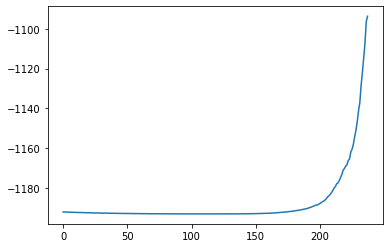

In [3]:
plt.plot(lik_ls[:238])

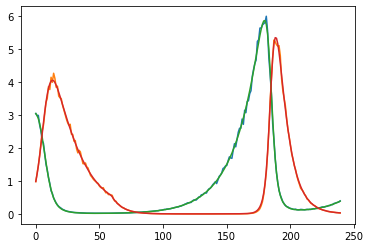

In [14]:
plt.plot(observations[:, 0])
plt.plot(observations[:, 1])
plt.plot(pointwise_xlatent_torch.detach().numpy()[:, 0])
plt.plot(pointwise_xlatent_torch.detach().numpy()[:, 1])


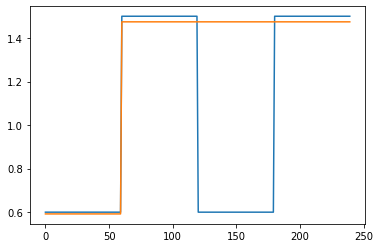

In [15]:
plt.plot(gamma_true)
plt.plot(construct(torch.tensor(vals_ls[-1]).reshape(-1, 1), occurence_times_ls[-1].astype(int)).numpy().reshape(-1, 1))

In [27]:
days = 20  
obs_per_day = 12
nobs = 240
X = np.arange(0, days, 1./(obs_per_day * 1000))
alpha = 0.6
beta = 0.75 
delta = 1. 


gamma_true = np.concatenate((0.6 * np.ones(60), 1.5 * np.ones(60), 0.6 * np.ones(60), 1.5 * np.ones(60)))

def recover_data(alpha, beta, delta, gamma, days, obs_per_day, state0=[3., 1.], linspace=1000, noise=True):
    nobs = days
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((days * linspace * obs_per_day, 2))
    state_ls[0] = state0.copy()
    for i in range(1, linspace * days * obs_per_day):
        index = int((i - 1) / 1000)
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (
                    alpha * state_ls[i - 1][0] - beta * state_ls[i - 1][0] * state_ls[i - 1][1])
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (
                    delta * state_ls[i - 1][0] * state_ls[i - 1][1] - gamma[index]  * state_ls[i - 1][1])
    states = state_ls[::linspace]
    return states

for i in range(238):
    print(i)
    gamma = construct(torch.tensor(vals_ls[i]).reshape(-1, 1), occurence_times_ls[i].astype(int)).numpy().reshape(-1, 1)
    reconstructed = recover_data(alpha, beta, delta, gamma, days, obs_per_day)
    truth = recover_data(alpha, beta, delta, gamma_true, days, obs_per_day)
    plt.plot(reconstructed[:, 0])
    plt.plot(truth[:, 0], label='true')
    plt.plot(reconstructed[:, 1])
    plt.plot(truth[:, 1], label='true')
    plt.legend()
    plt.savefig('new-LV-x/plot-'+str(i)+'.png')
    plt.clf()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237


<Figure size 432x288 with 0 Axes>

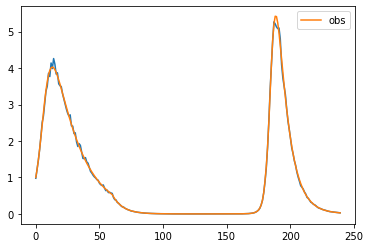

In [26]:
plt.plot(observations[:, 1])
plt.plot(truth[:, 1], label='obs')
plt.legend()

In [25]:
time_constant_param_ls_tmp

[tensor([0.6548], dtype=torch.float64, requires_grad=True),
 tensor([0.8838], dtype=torch.float64, requires_grad=True),
 tensor([0.8602], dtype=torch.float64, requires_grad=True)]

In [28]:
inferred_theta
# sigma_torch

array([0.6398801 , 0.86445002, 0.75831829, 0.73189768])